# 6. Decision Trees and Ensemble Learning

This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

- Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
#!wget $data

In [4]:
df = pd.read_csv(data)

In [5]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [9]:
status_values = {
    1:"ok",
    2:"default",
    0:"unk"
}

df.status = df.status.map(status_values)

In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [13]:
df.income.max()

np.int64(99999999)

In [14]:
for c in ['income', 'assets', 'debt']:

    df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

In [15]:
df.income.max()

np.float64(959.0)

In [16]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [17]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [18]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2, random_state = 11)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state = 11)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_train = (df_train['status']=='default').astype(int).values
y_val = (df_val['status']=='default').astype(int).values
y_test = (df_test['status']=='default').astype(int).values

In [21]:
del df_train['status']
del df_val['status']
del df_test['status']

In [22]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [23]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [24]:
xi = df_train.iloc[0].to_dict()

In [25]:
assess_risk(xi)

'ok'

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [27]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [28]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [29]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [30]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
y_pred = dt.predict_proba(X_val)[:,1]

In [32]:
roc_auc_score(y_val, y_pred)

0.6665556658836065

In [33]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [34]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [35]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train:',auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:',auc)

train: 0.7761016984958594
val: 0.7389079944782155


In [36]:
from sklearn.tree import export_text

In [37]:
print(export_text(dt, feature_names = dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



## 6.4 Decision tree learning algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [38]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [39]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [40]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [41]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [42]:
from IPython.display import display

In [43]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [44]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [45]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [46]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [47]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## 6.5 Decision trees parameter tuning

- selecting max_depth
- selecting min_samples_leaf

In [48]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train,y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.758
  10 -> 0.695
  15 -> 0.651
  20 -> 0.649
None -> 0.652


In [49]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [50]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [51]:
df_scores.sort_values(by ='auc', ascending=False)

,max_depth,min_samples_leaf,auc
19,6,15,0.785471
18,6,10,0.777803
22,6,100,0.776434
12,5,20,0.774028
20,6,20,0.773982
11,5,15,0.772723
23,6,200,0.768267
9,5,5,0.767755
8,5,1,0.766496
3,4,15,0.763726


In [52]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.760
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

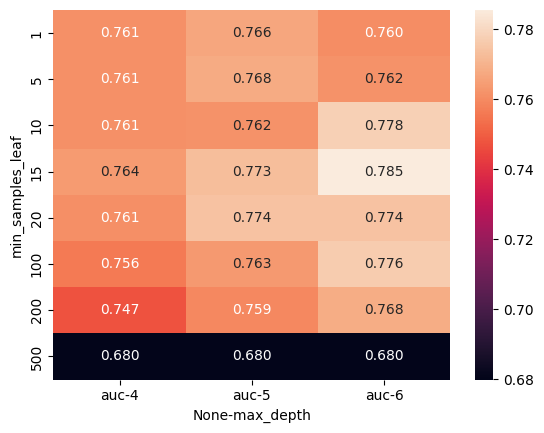

In [53]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [54]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- income <= 117.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  117.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.6 Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [58]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7816200867017026

In [59]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))

In [60]:
df_scores = pd.DataFrame(scores,columns=['no_of_estimators','auc'])

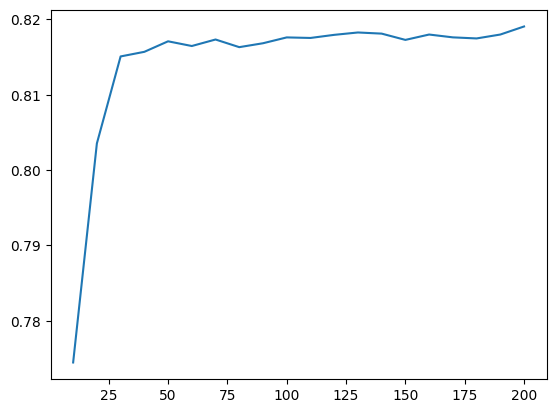

In [61]:
plt.plot(df_scores.no_of_estimators, df_scores.auc) 

In [62]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [63]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

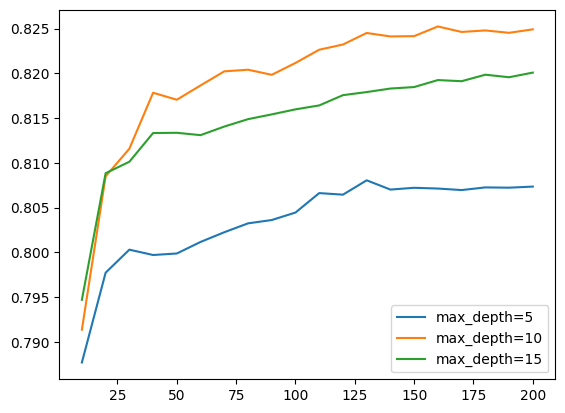

In [64]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [65]:
max_depth = 10

In [66]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [67]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

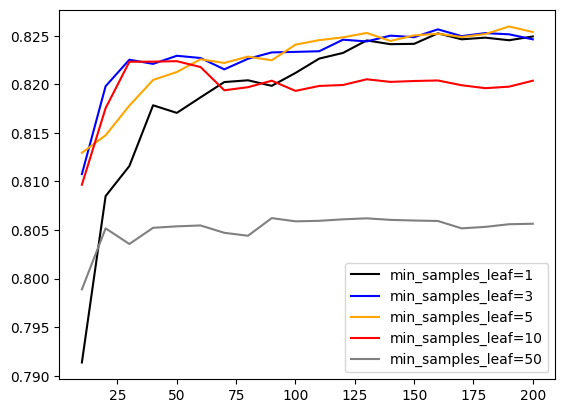

In [68]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [69]:
min_samples_leaf = 3

In [70]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [71]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [72]:
import xgboost as xgb

In [73]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names = features)

In [74]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [75]:
y_pred = model.predict(dval)

In [76]:
roc_auc_score(y_val,y_pred)

0.8118506454190986

In [77]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval=3,
                  num_boost_round=50)

In [79]:
print(output.stdout)

[0]	train-auc:0.86653	val-auc:0.77999
[3]	train-auc:0.91573	val-auc:0.79997
[6]	train-auc:0.93630	val-auc:0.81043
[9]	train-auc:0.95012	val-auc:0.81185
[12]	train-auc:0.95936	val-auc:0.81433
[15]	train-auc:0.96767	val-auc:0.81993
[18]	train-auc:0.97336	val-auc:0.82015
[21]	train-auc:0.97773	val-auc:0.81969
[24]	train-auc:0.98102	val-auc:0.81686
[27]	train-auc:0.98563	val-auc:0.81634
[30]	train-auc:0.98844	val-auc:0.81613
[33]	train-auc:0.99109	val-auc:0.81584
[36]	train-auc:0.99313	val-auc:0.81451
[39]	train-auc:0.99338	val-auc:0.81459
[42]	train-auc:0.99503	val-auc:0.81396
[45]	train-auc:0.99568	val-auc:0.81392
[48]	train-auc:0.99700	val-auc:0.81335
[49]	train-auc:0.99719	val-auc:0.81273



In [80]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [81]:
df_score = parse_xgb_output(output)

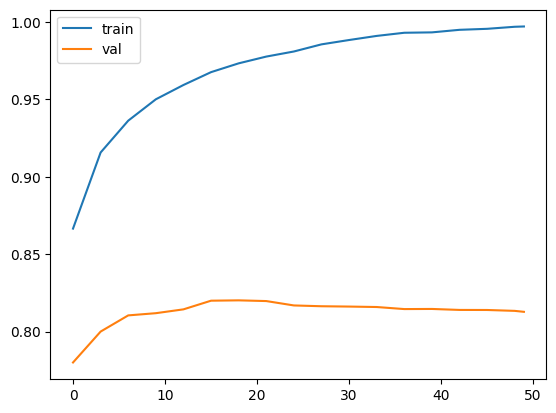

In [82]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

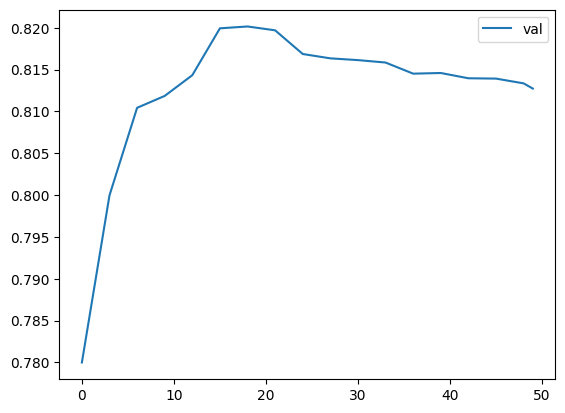

In [83]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

- eta
- max_depth
- min_child_weight

In [84]:
scores = {}

In [85]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [86]:
#scores = {}

In [87]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

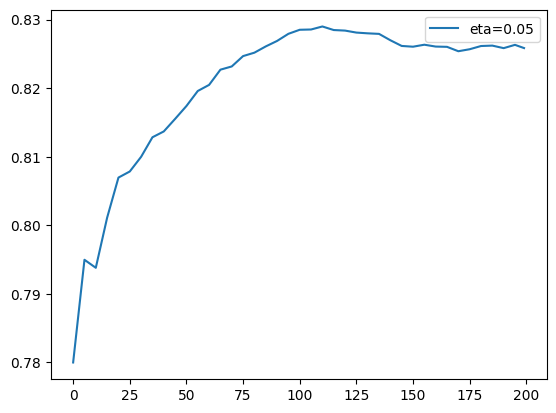

In [88]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

In [89]:
scores = {}

In [90]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [91]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

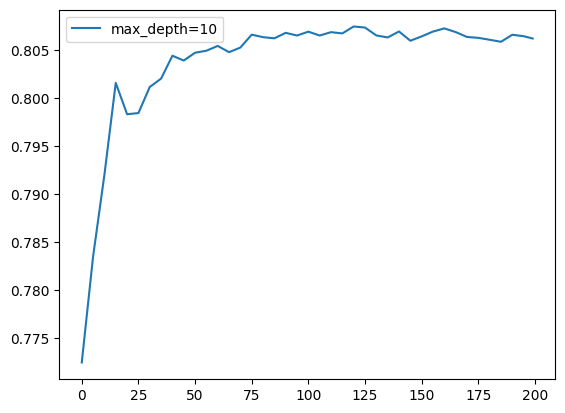

In [92]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

In [93]:
scores = {}

In [94]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 50,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [95]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=50'

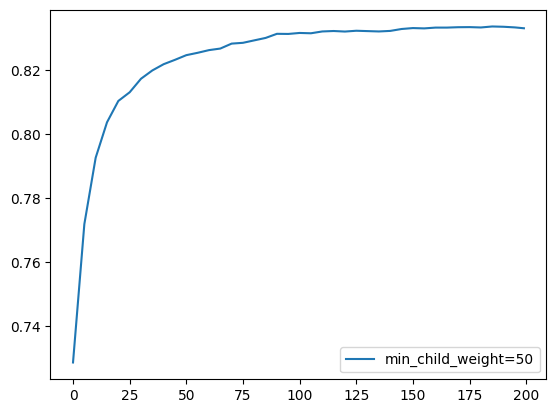

In [96]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

In [97]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

- subsample and colsample_bytree
- lambda and alpha

## 6.9 Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [98]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [99]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [100]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [101]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [102]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [103]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8334715797631446

In [104]:
df_full_train = df_full_train.reset_index(drop=True)

In [105]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [106]:
del df_full_train['status']

In [107]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [113]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [114]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [115]:
y_pred = model.predict(dtest)

In [116]:
roc_auc_score(y_test, y_pred)

0.8299814280826938

## 6.10 Summary
- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

##6.11 Explore more
- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
- XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
Experiment with other XGBoost parameters: subsample and colsample_bytree.
When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for random forest (it's the same for plain decision trees) and for xgboost
Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.